This benchmark shows advantages of using bcp over odbc. It is quite crude, however, and in practice the results may vary strongly depending on your SQL Server version, the number/kind of indexes on a table, the connectivity to the database and the difference in scale between the ETL server and SQL Server among other factors. That being said, I would expect similar tendencies.

# Imports & Connection setup

In [ ]:
%pip install pyodbc pandas matplotlib

In [2]:
import arrow_bcp as ab
import pyarrow as pa
import pyodbc
import pandas as pd
import random
import datetime
from decimal import Decimal
import time
import timeit

Database connection details need to be filled in

In [3]:
SQL_URL = "##########"
SQL_DB = "##########"
SQL_LOGIN = "##########"
SQL_PWD = "##########"

In [4]:
NR_ROWS = 200_000
NR_BATCHES = 1
NR_REPS = 5

In [5]:
pyodbc_con = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SQL_URL};DATABASE={SQL_DB};UID={SQL_LOGIN};PWD={SQL_PWD}"
)
bcp_con = ab.ConnectionInfo(
    (f"-S tcp:{SQL_URL},1433 -d {SQL_DB} -U {SQL_LOGIN} -P {SQL_PWD}").split()
)
bcp_con_tablock = ab.ConnectionInfo(
    (f"-S tcp:{SQL_URL},1433 -d {SQL_DB} -U {SQL_LOGIN} -P {SQL_PWD} -h TABLOCK").split()
)

# Generate random data

In [6]:
alphabet = [
    chr(code_point) for current_range in [
        (0x0021, 0x0021),
        (0x0023, 0x0026),
        (0x0028, 0x007E),
        (0x00A1, 0x00AC),
        (0x00AE, 0x00FF),
        (0x0100, 0x017F),
        (0x0180, 0x024F),
        (0x2C60, 0x2C7F),
        (0x16A0, 0x16F0),
        (0x0370, 0x0377),
        (0x037A, 0x037E),
        (0x0384, 0x038A),
        (0x038C, 0x038C),
    ]
    for code_point in range(current_range[0], current_range[1] + 1)
]
def random_utf8(length):
    return ''.join(random.choices(alphabet, k=length))

dmin, dmax = pa.array([datetime.date(1,1,1), datetime.date(9999,12,31)], type=pa.date32()).cast(pa.int32()).to_pylist()
tmin, tmax = pa.array([0, datetime.time(23,59,59,999999)], type=pa.time64('us')).cast(pa.int64()).to_pylist()
dtmin, dtmax = pa.array([datetime.datetime(1,1,1), datetime.datetime(9999,12,31,23,59,59,999999)], type=pa.timestamp("us")).cast(pa.int64()).to_pylist()

gen_fns = {
    "bigint": ("bigint", pa.int64(), lambda x: min(2**63 * (2 * x - 1), 2**63-1)),
    "int": ("int", pa.uint16(), lambda x: (2**16 - 1) * x),
    "bit": ("bit", pa.bool_(), lambda x: x >= 0.5),
    "decimal": ("decimal(15, 10)", pa.decimal128(15, 10), lambda x: Decimal(((2 * x - 1) * (10**15 - 1)) // 1) / 10**10),
    "float": ("float", pa.float64(), lambda x: (1 if x >= 0.5 else -1) * (x + 1) * 2.0 ** ( 511 * (2 * x - 1))),
    "date": ("date", pa.date32(), lambda x: x * (dmax - dmin) + dmin),
    "time": ("time", pa.time64("us"), lambda x: x * (tmax - tmin) + tmin),
    "datetime2": ("datetime2", pa.timestamp("us"), lambda x: x * (dtmax - dtmin) + dtmin),
    "unicode": ("nvarchar(max)", pa.string(), lambda x: random_utf8(int(x**4 * 4000))),
    "chars_of_length_4000": ("nvarchar(max)", pa.string(), lambda x: random_utf8(4000)),
    "chars_of_length_4001": ("nvarchar(max)", pa.string(), lambda x: random_utf8(4001)),
}

arrays = []
for _, tp, fn in gen_fns.values():
    vals = [
        None if random.random() > 0.75 else
        fn(random.random()) for _ in range(NR_ROWS - 3)
    ]
    vals.insert(random.choice(range(len(vals))), fn(1))
    vals.insert(random.choice(range(len(vals))), fn(0.5))
    vals.insert(random.choice(range(len(vals))), fn(0))
    arrays.append(pa.array(vals, type=tp))

batch_complete = pa.record_batch(arrays, names=list(gen_fns.keys()))

# Set up benchmarking procedure

In [7]:
def setup(cols: list[str]):
    "Reset table in database"
    def f():
        pyodbc_con.execute(f"""
            drop table if exists test
            create table test(
                {", ".join(col + " " + gen_fns[col][0] for col in cols)}
            )
        """)
        pyodbc_con.commit()
    return f

def time_pyodbc(tablock: bool, cols: list[str], n_rows: int):
    batch = batch_complete[:n_rows].select(cols)
    # pyodbc consumes python datatypes, we don't want to time this so we convert ahead of time
    batch_as_tuples = [tuple(row.values()) for row in batch.to_pylist()]

    # pyodbc has the real advantage of being able to cache connections and cursors / statement handles
    # so we don't time the connection setup
    cur = pyodbc_con.cursor()
    cur.fast_executemany = True
    def f():
        cur.executemany(f"""
            insert into test{" with(TABLOCK)" if tablock else ""}
            values ({", ".join("?"*len(cols))})
        """, batch_as_tuples)
        pyodbc_con.commit()
    return f

def time_bcp(tablock: bool, cols: list[str], n_rows: int):
    batch = batch_complete[:n_rows].select(cols)

    def f():
        (bcp_con_tablock if tablock else bcp_con).insert_arrow("test", [batch])
    return f

In [8]:
class Timer:
    "Dummy class to make timeit measure process time and perf counter simultaneously"
    def __init__(self, proc, perf):
        self.proc = proc
        self.perf = perf
    def time():
        return Timer(time.process_time(), time.perf_counter())
    def __sub__(self, other):
        return Timer(self.proc - other.proc, self.perf - other.perf)

In [9]:
def benchmark(columns: list[str], tablock: bool, n_rows: int, all_columns: bool):
    "Perform the benchmark and generate a plotly figure"
    bcp_perf = {}
    bcp_proc = {}
    pyodbc_perf = {}
    pyodbc_proc = {}

    for col in columns:
        t_bcp = timeit.timeit(
            stmt=time_bcp(tablock, [col], n_rows),
            setup=setup([col]),
            timer=Timer.time,
            number=NR_REPS,
        )
        bcp_perf[f"Only {col}"] = t_bcp.perf
        bcp_proc[f"Only {col}"] = t_bcp.proc

        t_pyodbc = timeit.timeit(
            stmt=time_pyodbc(tablock, [col], n_rows),
            setup=setup([col]),
            timer=Timer.time,
            number=NR_REPS,
        )

        pyodbc_perf[f"Only {col}"] = t_pyodbc.perf
        pyodbc_proc[f"Only {col}"] = t_pyodbc.proc
        print(".", end="")

    if all_columns:
        t_bcp = timeit.timeit(
            stmt=time_bcp(tablock, columns, n_rows),
            setup=setup(columns),
            timer=Timer.time,
            number=NR_REPS,
        )
        bcp_perf["All columns"] = t_bcp.perf
        bcp_proc["All columns"] = t_bcp.proc

        t_pyodbc = timeit.timeit(
            stmt=time_pyodbc(tablock, columns, n_rows),
            setup=setup(columns),
            timer=Timer.time,
            number=NR_REPS,
        )

        pyodbc_perf["All columns"] = t_pyodbc.perf
        pyodbc_proc["All columns"] = t_pyodbc.proc

    df = pd.DataFrame({
        "Elapsed bcp": bcp_perf,
        "Elapsed pyodbc": pyodbc_perf,
        "CPU bcp": bcp_proc,
        "CPU pyodbc": pyodbc_proc,
    })
    df.plot(kind="barh", figsize=[12, 6])
    return df.T

# Results

## Normal case

The first benchmark represents a typical workload intended for this module

From the difference between perf/elapsed time and proc/CPU time spent in both bcp and pyodbc benchmarks, we can see that most of the time is not eaten up by the CPU running the notebook. This indicates that the reason pyodbc is slower has nothing to do with the fact that it is using python data types, which are generally slower.

Instead most of the time is spent on the SQL Server side, which, in the case of pyodbc has a very high CPU utilization, as it's trying to figure out how to insert the data and log the inserts.

Having looked at the odbc specification and pyodbc implementation for quite a bit, I think that pyodbc handles inserts about as well as the specification allows.

.........

,Only bigint,Only int,Only bit,Only decimal,Only float,Only date,Only time,Only datetime2,Only unicode,All columns
Elapsed bcp,3.814066,3.813875,3.828136,4.042081,3.573520,3.840329,4.091075,3.945898,51.918562,55.676529
Elapsed pyodbc,25.000829,24.870293,24.981263,26.712410,25.127409,25.293331,25.399346,25.217310,119.359981,124.717382
CPU bcp,0.097428,0.129928,0.115367,0.185219,0.120996,0.213216,0.330724,0.222442,1.262050,1.768699
CPU pyodbc,1.262390,1.276154,1.262438,2.385365,1.479365,1.589894,1.456422,1.598922,4.720991,7.980290


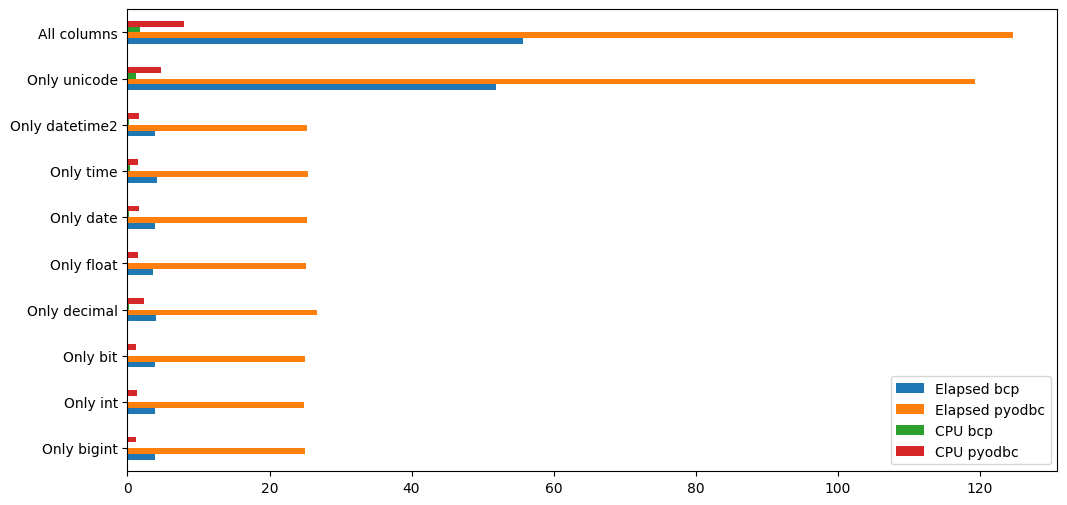

In [10]:
benchmark(list(gen_fns.keys())[:-2], False, NR_ROWS, True)

Now we will do the same benchmark but with a lock on the table.

.........

,Only bigint,Only int,Only bit,Only decimal,Only float,Only date,Only time,Only datetime2,Only unicode,All columns
Elapsed bcp,1.363855,1.369528,1.391989,1.835343,1.425205,1.361423,1.570051,1.641132,40.096661,34.034453
Elapsed pyodbc,23.290618,23.118965,23.439102,25.085869,23.901022,23.378068,23.396547,23.697274,110.533572,118.204705
CPU bcp,0.087602,0.168463,0.194559,0.242700,0.143175,0.135384,0.228456,0.256863,1.146310,1.725965
CPU pyodbc,1.558598,1.562552,1.555363,2.787146,1.705063,1.491043,1.578604,1.751548,4.311963,8.019612


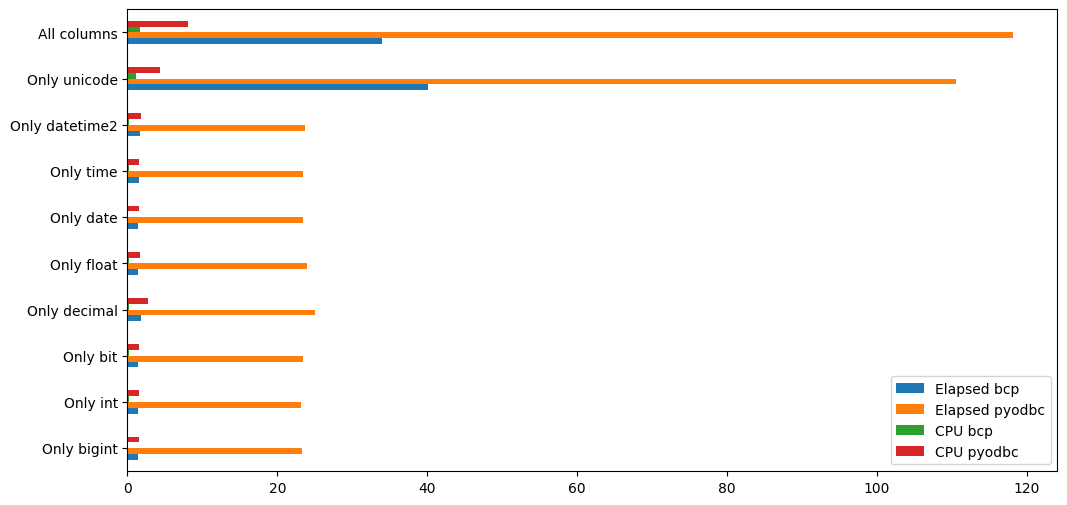

In [11]:
benchmark(list(gen_fns.keys())[:-2], True, NR_ROWS, True)

As we can see, bulk inserts can use a table lock more effectively than odbc inserts.

## Small Batchsize

The next benchmark demonstrates that when inserting small amounts of rows, the fact that odbc can cache the database connection and bcp needs to reconnect for every bulk insert (as it runs in a subprocess) can be more important than bcp's better performance

.........

,Only bigint,Only int,Only bit,Only decimal,Only float,Only date,Only time,Only datetime2,Only unicode,All columns
Elapsed bcp,0.365966,0.476698,0.489117,0.415202,0.418948,0.430072,0.306026,0.335738,0.597185,0.598035
Elapsed pyodbc,0.360490,0.261609,0.289627,0.351819,0.359860,0.272308,0.273524,0.291634,0.448871,0.484801
CPU bcp,0.008425,0.014384,0.019965,0.014458,0.015210,0.014905,0.009114,0.012225,0.018972,0.023678
CPU pyodbc,0.019096,0.014294,0.015278,0.035758,0.013623,0.015859,0.009351,0.008640,0.028484,0.053296


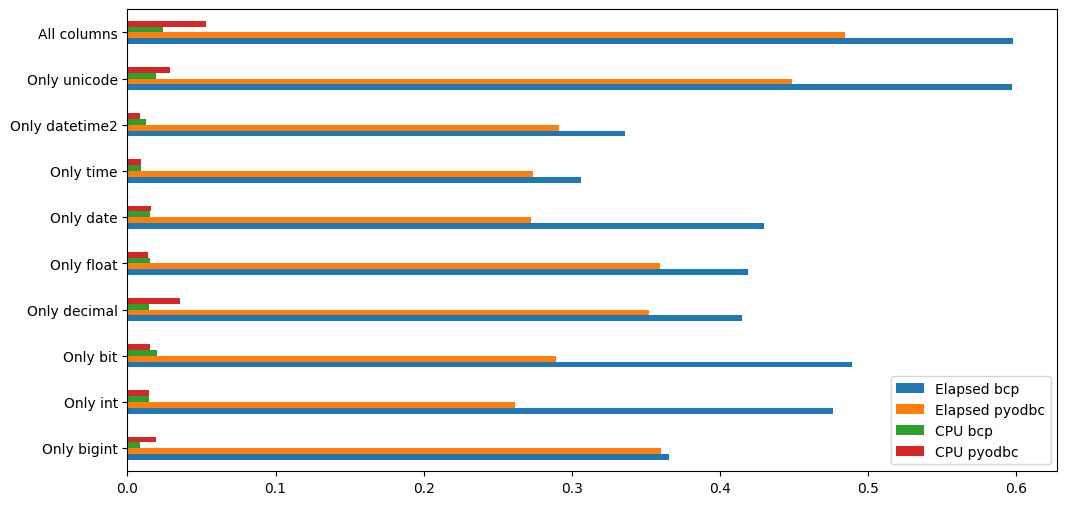

In [12]:
benchmark(list(gen_fns.keys())[:-2], False, 1_000, True)

# You win some, you lose some

Sadly bcp did not get blessed with a very good implementation for large data, that is cells with more than 8k bytes. For unicode this translates to 4k characters.

I have tried a number of tweaks to the bcp insert process, including using wide characters instead of utf-8, importing as csv instead of using native datatypes and doing the same using the `BULK IMPORT` statement instead of bcp. However the situation does not improve.

On the plus side, this effect seems to scale linearly with the amount of rows that have cells larger than 8k bytes, so if there are only a few large entries, this will probably not be noticable.

..

,Only chars_of_length_4000,Only chars_of_length_4001
Elapsed bcp,1.276053,9.448878
Elapsed pyodbc,1.534308,1.173651
CPU bcp,0.067409,0.103172
CPU pyodbc,0.077309,0.107783


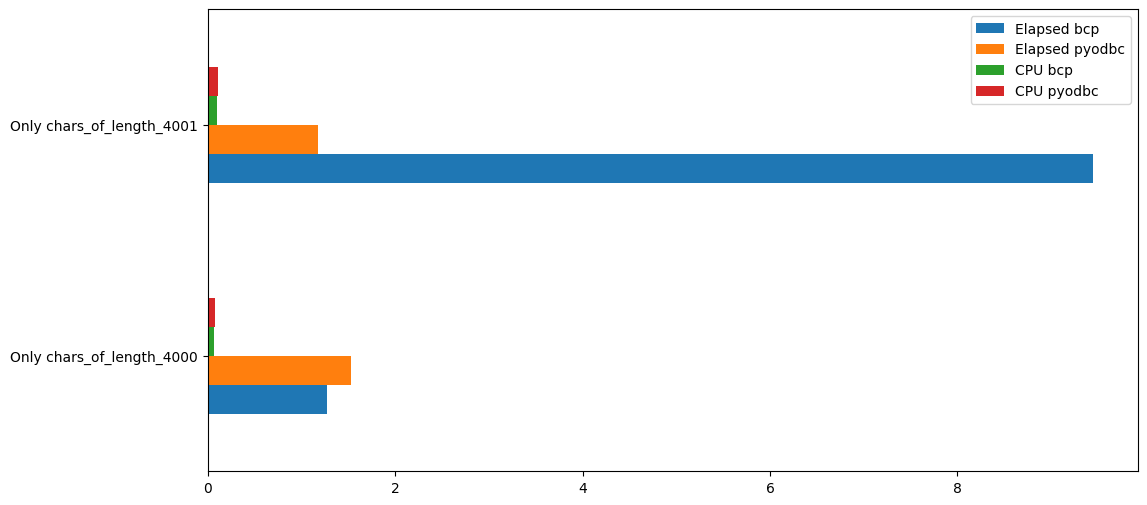

In [13]:
benchmark(list(gen_fns.keys())[-2:], False, 1_000, False)

# Notes on bandwidth

If network bandwidth is the limiting factor, bcp should also come out ahead by a significant margin. Reasons for that are different data types, for example:

- For both odbc and bcp, each cell gets an indicator variable. With odbc its size is always 8 bytes, with bcp 1 byte is enough, at least for non char/binary types
- Odbc dates send year (2 bytes), month and day (1 byte each) separately, resulting in 4 bytes. bcp uses ordinal dates, so 3 bytes are enough. Same story with datetime
- Odbc often treats character data as utf-16, bcp sends data as utf-8 and lets SQL Server translate. This results in half the bytes in many cases
- Odbc usually sends decimal data as strings because odbc's numeric data type is less reliable. Bcp is sending decimals using integer encoding